In [21]:
import os
import requests
import json
from dotenv import load_dotenv

from urllib.parse import urlencode

load_dotenv()

True

In [12]:
API_VERSION = '5.131'
CLIENT_ID = 51812043
SECRET_KEY = os.getenv('VK_SECRET_KEY')

In [8]:
auth_url = 'https://oauth.vk.com/authorize'

params = {
    'client_id': CLIENT_ID,
    'redirect_uri': 'https://oauth.vk.com/blank.html',
    'display': 'page',
    'scope': 'ads,offline',
    'response_type': 'code',
    'v': API_VERSION,
}

print(auth_url + '?' + urlencode(params))

https://oauth.vk.com/authorize?client_id=51812043&redirect_uri=https%3A%2F%2Foauth.vk.com%2Fblank.html&display=page&scope=ads%2Coffline&response_type=code&v=5.131


In [9]:
code = 'c2bdb6350c8239214e'

In [15]:
access_token_url = 'https://oauth.vk.com/access_token'

params = {
    'client_id': CLIENT_ID,
    'client_secret': SECRET_KEY,
    'redirect_uri': 'https://oauth.vk.com/blank.html',
    'code': code,
}

res = requests.post(access_token_url, params=params)
res

<Response [200]>

In [17]:
auth_results = res.json()

In [23]:
access_token = auth_results['access_token']
user_id = auth_results['user_id']

In [24]:
with open('vk_creds.json', 'w') as f:
    json.dump(auth_results, f)

In [35]:
def get_data(method, params, access_token):
    params = urlencode(params)

    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    url = f'https://api.vk.com/method/{method}?{params}'

    res = requests.get(url, headers=headers)
    return res

In [38]:
m = 'ads.getAccounts'
params = {'v': API_VERSION}

res = get_data(m, params, access_token)
res

<Response [200]>

In [40]:
accounts = res.json()

In [49]:
account_name = 'Smysl.io'
account = [a for a in accounts['response'] if a['account_name'] == account_name][0]
account_id = account['account_id']

In [69]:
m = 'ads.getCampaigns'
params = {
    'v': API_VERSION,
    'account_id': account_id
    }

res = get_data(m, params, access_token)
res

<Response [200]>

In [72]:
res.json()
campaigns = res.json()['response']
campaigns

[{'all_limit': '0',
  'day_limit': '0',
  'id': 1017415637,
  'name': '20210102_metrics',
  'start_time': 0,
  'status': 1,
  'stop_time': 0,
  'type': 'normal',
  'create_time': 1609583475,
  'goal_type': 0,
  'user_goal_type': 0,
  'is_cbo_enabled': False,
  'update_time': 1609583475}]

In [73]:
m = 'ads.getAds'
params = {
    'v': API_VERSION,
    'account_id': account_id
    }

res = get_data(m, params, access_token)
res

<Response [200]>

In [78]:
res.json()
ads = res.json()['response']

In [86]:
ad_ids = [str(a['id']) for a in ads]

In [89]:
m = 'ads.getStatistics'
params = {
    'v': API_VERSION,
    'account_id': account_id,
    'ids_type': 'ad',
    'ids': ','.join(ad_ids),
    'period': 'day',
    'date_from': '2010-01-01',
    'date_to': '2023-01-01'
    }

res = get_data(m, params, access_token)
res

<Response [200]>

In [109]:
stats = res.json()['response']

data = []

for stat in stats:
    row = {'id': stat['id']}
    for period in stat['stats']:
        row = row | period
        data.append(row)

In [112]:
import pandas as pd

df = pd.DataFrame(data)

In [122]:
df['spent'] = df['spent'].astype('float')

/var/folders/s_/t8ytmm9940j564xd698kgmm00000gn/T/ipykernel_47077/1276997166.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df.groupby('day').agg({'spent': sum}).plot(figsize=(16,6))


<Axes: xlabel='day'>

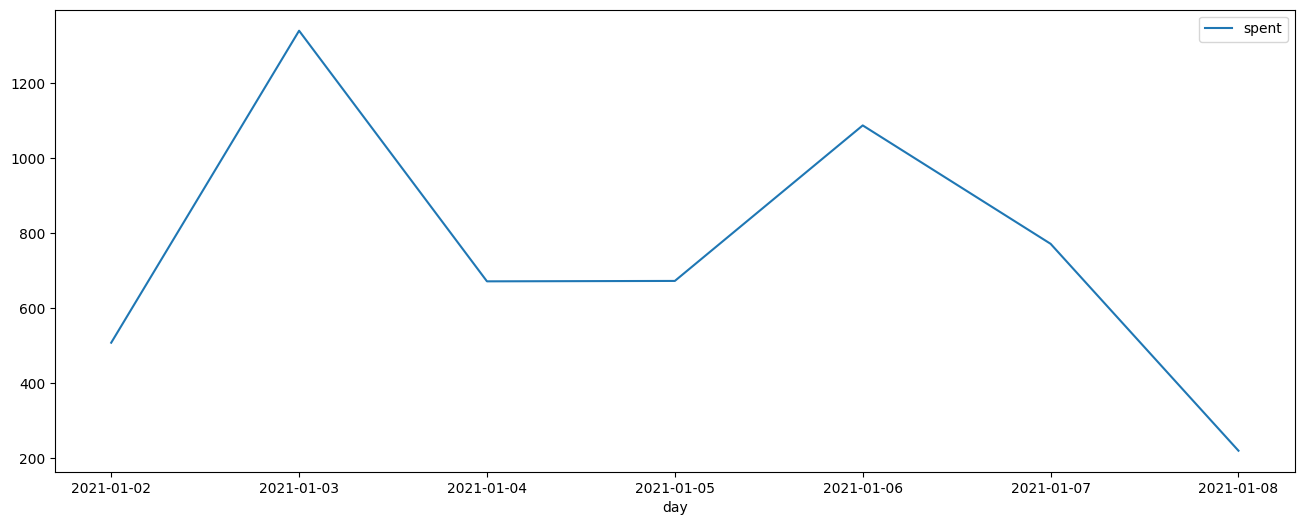

In [124]:
df.groupby('day').agg({'spent': sum}).plot(figsize=(16,6))